In [1]:
import sys
import os

# Add parent directory to path if needed
notebook_dir = os.path.dirname(os.path.abspath(''))
if notebook_dir not in sys.path:
    sys.path.append(os.path.dirname(notebook_dir))

# Import config
from lcne_transcriptomics.notebooks.config import *

# Set up plotting
configure_matplotlib()

# Set figure directory 
SAVE_FIGURES = True
fig_path = MERFISH_FIGURE_DIR

In [2]:

%load_ext autoreload
%autoreload 2
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# With:
from lcne_transcriptomics import processing, utils, plotting, heatmap
from lcne_transcriptomics import imputations, spatial_cca, pseudoclusters, pseudocluster_imputations


plt.rcParams.update({
    "svg.fonttype": 'none',
    "pdf.fonttype": 42,
    'ps.fonttype': 42,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})



import matplotlib.font_manager as fm
font_path = '/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttc'
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']
else:
    print("Warning: Helvetica font not found. Using default font.")

print(f"scanpy version: {sc.__version__}")

scanpy version: 1.10.4


# Data Loading and Preprocessing

In [3]:
# Load mesh data
print("Loading mesh data...")
allmeshes = utils.load_mesh()
mesh = allmeshes['250513_LC_core_67_mesh_shrunk']
mesh.vertices /= 25  # Scale vertices to mm

# Load MERFISH data
print("Loading MERFISH data...")
filename = os.path.join(MERFISH_DATA_DIR, 'adata_mer_subset_2_6k.h5ad')
adata_mer = sc.read_h5ad(filename)
print(f"Original data shape: {adata_mer.shape}")

# Filter out cluster 5
adata_mer = adata_mer[adata_mer.obs['leiden']!='5',:]
print(f"After filtering: {adata_mer.shape}")

# Create UMAP embedding for visualization
print("Creating UMAP embedding...")
umap_random_state = 307
sc.pp.neighbors(adata_mer, use_rep="X_scVI", random_state=umap_random_state)
sc.tl.umap(adata_mer, random_state=210)

Loading mesh data...
Loading MERFISH data...
Original data shape: (2651, 315)
After filtering: (2252, 315)
Creating UMAP embedding...


/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


# Perform CCA Analysis

In [4]:
# Prepare data for CCA
print("Performing CCA between gene expression and spatial coordinates...")
scl_multiplier = 25  # Scaling factor for spatial coordinates
S_mer = processing.get_hemi(adata_mer.obsm['spatial'])  # Process spatial coordinates

# Run CCA to find correlations between gene expression and spatial location
n_components = 2
cca, X_c, S_c, canonical_correlations = spatial_cca.perform_cca(
    adata_mer.X, 
    S_mer, 
    n_components=n_components, 
    scl_multiplier=scl_multiplier
)
print(f"Canonical correlations: {canonical_correlations}")

Performing CCA between gene expression and spatial coordinates...
Canonical correlations: [np.float64(0.9292436074120816), np.float64(0.801906401170235)]


# Visualize CCA Results in Spatial Coordinates



Visualizing CCA component 1 in spatial coordinates...
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/cca.svg
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/cca.png


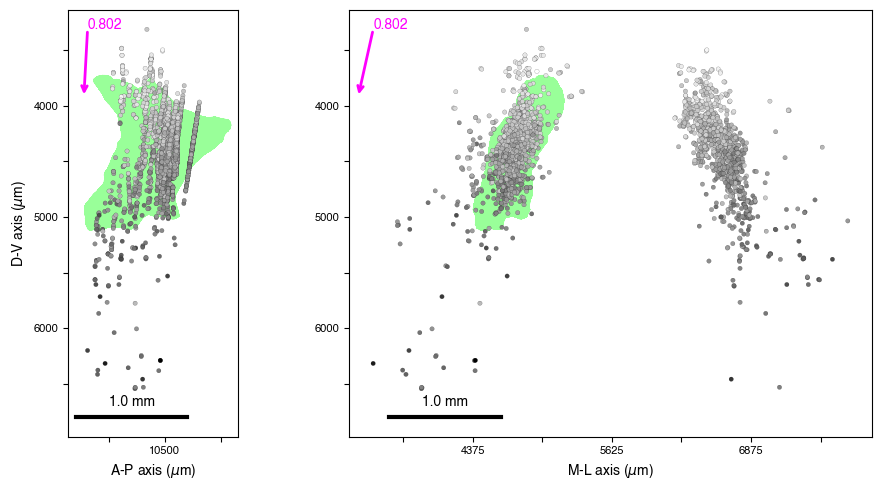

In [5]:
# Visualize CCA component 1 in sagittal and coronal views
print("Visualizing CCA component 1 in spatial coordinates...")
s = 10
k = 1  # Component to visualize (0-indexed)
scale_factor = 1 * scl_multiplier
vector = (cca.y_weights_[:, k])
vector_scaled = vector * scale_factor
allspatial = adata_mer.obsm['spatial'].copy()

fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(10, 5),
    gridspec_kw={'width_ratios': [1, 4]}
)

# Sagittal view (A-P vs D-V)
ax1.triplot(mesh.vertices.T[0], mesh.vertices.T[1], mesh.faces, color='lime', alpha=0.4)
ax1.scatter(allspatial[:, 0], allspatial[:, 1], c=X_c[:, k], s=s, edgecolor='k', linewidth=0.1, cmap='Greys')
ax1.set_aspect('equal')

# Add vector arrow
start_point_all = np.min(allspatial, 0)
start_point = (start_point_all[0], start_point_all[1])
end_point = (start_point_all[0] + vector_scaled[0], start_point_all[1] + vector_scaled[1])
ax1.annotate('',
             xy=end_point,
             xytext=start_point,
             arrowprops=dict(arrowstyle="->", color="magenta", lw=2))
ax1.text(start_point[0], start_point[1], np.around(canonical_correlations[k], 3).astype(str), color='magenta')

ax1.invert_yaxis()
ax1.set_ylabel("D-V axis ($\mu$m)")
ax1.set_xlabel("A-P axis ($\mu$m)")
xt = ax1.get_xticks(); yt = ax1.get_yticks()
ax1.set_xticks(xt); ax1.set_yticks(yt)
ax1.set_xticklabels(plotting.format_ticklabels(xt, scale=25))
ax1.set_yticklabels(plotting.format_ticklabels(yt, scale=25))
plotting.draw_scale_bar(ax1, length_px=40, linewidth=3, px_to_mm=25/1000)

# Coronal view (M-L vs D-V)
ax2.triplot(mesh.vertices.T[2], mesh.vertices.T[1], mesh.faces, color='lime', alpha=0.4)
sca = ax2.scatter(allspatial[:, 2], allspatial[:, 1], c=X_c[:, k], s=s, edgecolor='k', linewidth=0.1, cmap='Greys')
ax2.set_aspect('equal')

# Add vector arrow
start_point = (start_point_all[2], start_point_all[1])
end_point = (start_point_all[2] + vector_scaled[2], start_point_all[1] + vector_scaled[1])
ax2.annotate('',
             xy=end_point,
             xytext=start_point,
             arrowprops=dict(arrowstyle="->", color="magenta", lw=2))
ax2.text(start_point[0], start_point[1], np.around(canonical_correlations[k], 3).astype(str), color='magenta')

ax2.invert_yaxis()
ax2.set_xlabel("M-L axis ($\mu$m)")
xt = ax2.get_xticks(); yt = ax2.get_yticks()
ax2.set_xticks(xt); ax2.set_yticks(yt)
ax2.set_xticklabels(plotting.format_ticklabels(xt, scale=25))
ax2.set_yticklabels(plotting.format_ticklabels(yt, scale=25))
plotting.draw_scale_bar(ax2, length_px=40, linewidth=3, px_to_mm=25*1e-3)

fig.tight_layout()
save_figure("cca")
plt.show()

# Visualize CCA Component on UMAP


Visualizing CCA component on UMAP...
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_umap.svg
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_umap.png


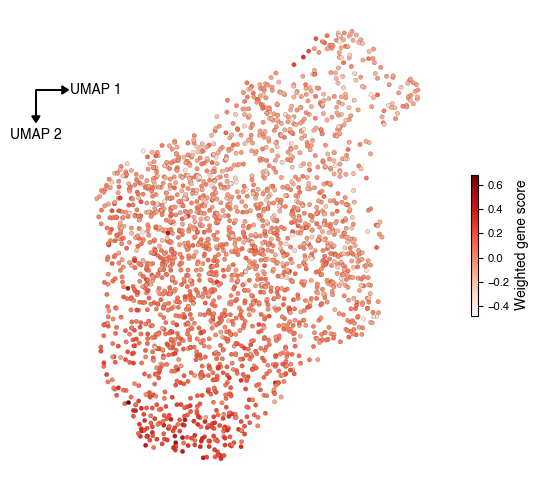

In [6]:
# Visualize CCA component on UMAP embedding
print("Visualizing CCA component on UMAP...")
s = 10
fs = 10
plt.figure(figsize=(7, 5))
ax = plt.gca()

sca = ax.scatter(adata_mer.obsm['X_umap'][:, 0], adata_mer.obsm['X_umap'][:, 1], 
                c=X_c[:, k], cmap='Reds', s=s, edgecolor='k', linewidth=0.1)
ax.set_aspect('equal')    
cbar = plt.colorbar(sca, ax=ax, label='Weighted gene score', shrink=0.3)

# Remove borders and ticks for clean appearance
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.invert_yaxis()

# Add UMAP axis labels
y0, x0 = np.min(adata_mer.obsm['X_umap'], 0)
y0 *= 1.4
x0 *= 0.8
ax.arrow(x0, y0, 1, 0, head_width=0.25, head_length=0.2,
         length_includes_head=True, linewidth=1, color='k')
ax.arrow(x0, y0, 0, 1, head_width=0.25, head_length=0.2,
         length_includes_head=True, linewidth=1, color='black')

ax.text(x0+1.05, y0, 'UMAP 1', va='center', ha='left', fontsize=fs)
ax.text(x0, y0+1.6, 'UMAP 2', va='bottom', ha='center', fontsize=fs)
plt.tight_layout()
save_figure("merfish_umap")
plt.show()

# Find Genes Correlated with CCA Direction


In [7]:
# Find genes correlated with the CCA direction
print("Finding genes correlated with CCA direction...")
direction_of_interest = -cca.y_weights_[:, 1]
direction_norm = direction_of_interest / np.linalg.norm(direction_of_interest)
projected = adata_mer.obsm['spatial'] @ direction_norm

# Convert sparse matrix to numpy array if needed
if hasattr(adata_mer.X, 'toarray'):
    X = adata_mer.X.toarray()
else:
    X = np.array(adata_mer.X)

gene_names = adata_mer.var_names
results = []
for i, gene in enumerate(gene_names):
    expr = X[:, i]
    corr, pval = spearmanr(expr, projected)
    results.append((gene, corr, pval))

df_results = pd.DataFrame(results, columns=['gene', 'spearman_corr', 'p_value'])
df_results_sorted = df_results.sort_values(by='spearman_corr', key=lambda s: s.abs(), ascending=False)

print("Top 10 correlated genes:")
print(df_results_sorted.head(10))

Finding genes correlated with CCA direction...
Top 10 correlated genes:
        gene  spearman_corr        p_value
269    Tacr3      -0.513575  8.165183e-152
197     Pdyn       0.485465  1.682166e-133
275  Tmem178      -0.473851  2.028019e-126
183    Oprm1       0.445951  1.738565e-110
281     Trhr       0.408585   2.361967e-91
194   Pde11a       0.397179   5.577201e-86
86      Esr1      -0.374459   6.875219e-76
161     Nefh      -0.366549   1.464832e-72
99      Gad2       0.356535   1.769856e-68
119      Grp      -0.350668   3.731286e-66


# Gene Imputation and Visualization

In [8]:
# Load scRNA-seq data for imputation
print("Loading scRNA-seq data for imputation...")
adata_foo = sc.read_h5ad(os.path.join(SNRNA_DATA_DIR, "snRNAseq_LCNE_BN_d4_merbar_1-5k.h5ad"))
adata_sc = sc.AnnData(adata_foo.layers['BN'])
adata_sc.obs = adata_foo.obs.copy()
adata_sc.obsm = adata_foo.obsm.copy()
adata_sc.var = adata_foo.var.copy()

# Subset MERFISH data to match genes in scRNA-seq
var_names = adata_mer.var_names.intersection(adata_sc.var_names)
adata_mer_foo = adata_mer[:, var_names]
print(f"Number of shared genes for imputation: {len(var_names)}")

# Impute MERFISH data
print("Imputing gene expression data...")
adata_mer_imputed = imputations.impute_mer_data(adata_sc, adata_mer_foo, k=200, n_hvg=None)
adata_mer_imputed.obsm['spatial'] = adata_mer.obsm['spatial'].copy()

Loading scRNA-seq data for imputation...
Number of shared genes for imputation: 314
Imputing gene expression data...
union!  1768


# Visualize Selected Genes in Spatial Coordinates

Visualizing selected genes...
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/three_genes_examples.svg
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/three_genes_examples.png


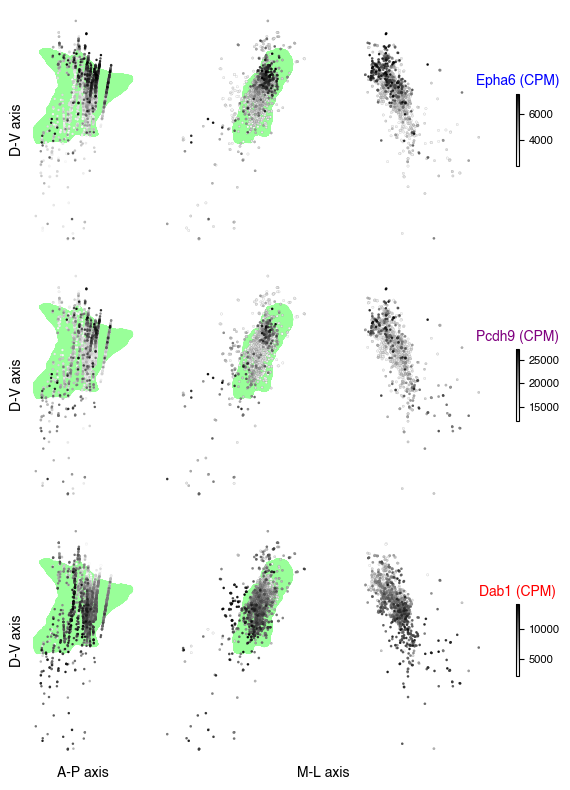

In [9]:
# Define function to visualize selected genes
def plot_selected_genes(adata_imputed, selected_genes, mesh, colors=None, s=3):
    """
    Plot selected genes in spatial coordinates
    
    Parameters:
    -----------
    adata_imputed : AnnData
        AnnData object with imputed gene expression
    selected_genes : list
        List of genes to visualize
    mesh : trimesh object
        Mesh for visualization
    colors : list, optional
        Colors for each gene
    s : int, default=3
        Point size
    """
    if colors is None:
        colors = ['blue', 'purple', 'red']
    
    fig, axes = plt.subplots(len(selected_genes), 2, figsize=(6, 8),
        gridspec_kw={'width_ratios': [1, 4]})
    
    for k, gene in enumerate(selected_genes):
        # Sagittal view
        ax = axes[k, 0]
        # Sort points by expression level to ensure high-expressing cells are on top
        plotorder = np.argsort(adata_imputed[:, gene].X.flatten())
        ax.triplot(mesh.vertices.T[0], mesh.vertices.T[1], mesh.faces, alpha=0.4, color='lime')
        sca = ax.scatter(
            adata_imputed.obsm['spatial'][plotorder, 0],
            adata_imputed.obsm['spatial'][plotorder, 1],
            cmap='Greys', s=s, edgecolor='k', linewidth=0.01,
            c=1e6*adata_imputed[plotorder, gene].X.toarray()
        )
        ax.invert_yaxis()
        ax.set_ylabel("D-V axis")
        ax.set_xlabel("A-P axis") if k == len(selected_genes)-1 else ax.set_xlabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Coronal view
        ax = axes[k, 1]
        ax.triplot(mesh.vertices.T[2], mesh.vertices.T[1], mesh.faces, alpha=0.4, color='lime')
        sca = ax.scatter(
            adata_imputed.obsm['spatial'][plotorder, 2],
            adata_imputed.obsm['spatial'][plotorder, 1],
            cmap='Greys', s=s, edgecolor='k', linewidth=0.05,
            c=1e6*adata_imputed[plotorder, gene].X.toarray()
        )
        cbar = plt.colorbar(sca, ax=ax, shrink=0.3)
        cbar.ax.xaxis.set_label_position('top')
        cbar.ax.set_xlabel(f"{gene} (CPM)", ha='center', va='bottom', color=colors[k])
        ax.set_xlabel("M-L axis") if k == len(selected_genes)-1 else ax.set_xlabel('')
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    
    fig.tight_layout()
    return fig

# Visualize selected genes
print("Visualizing selected genes...")
selected_genes = ['Epha6', 'Pcdh9', 'Dab1']
fig = plot_selected_genes(adata_mer_imputed, selected_genes, mesh)
save_figure("three_genes_examples")
plt.show()

# Generate Heatmap of Gene Expression


Preparing data for heatmap visualization...
Using 21 available genes for heatmap
Creating gene expression heatmap...
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_heatmap.svg
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_heatmap.png


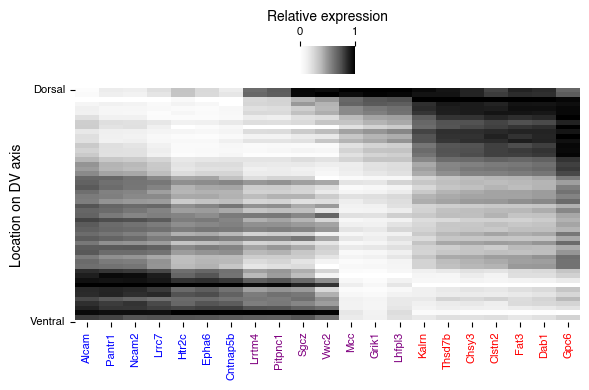

In [10]:
# Prepare data for heatmap visualization
print("Preparing data for heatmap visualization...")
k = 1
direction_of_interest = -(cca.y_weights_[:, k]) 
direction_norm = direction_of_interest / np.linalg.norm(direction_of_interest)
projected = adata_mer.obsm['spatial'] @ direction_norm

# Define genes for visualization (these comes from the all_fig_snRNA scripts)
allyourgenes = ['Epha6', 'Htr2c', 'Lrrc7', 'Alcam', 'Ncam2', 'Cntnap5b', 'Pantr1', 'Chsy3', 'Dab1', 'Fat3', 
                'Gpc6', 'Thsd7b', 'Kalrn', 'Clstn2', 'Lrrtm4', 'Vwc2', 'Sgcz', 'Mcc', 'Grik1', 'Pitpnc1', 'Lhfpl3']

# Check gene availability
available_genes = [gene for gene in allyourgenes if gene in adata_mer_imputed.var_names]
print(f"Using {len(available_genes)} available genes for heatmap")

# Sort cells by position along the CCA direction
t_order = np.argsort(projected)
inputheatmap = adata_mer_imputed[:, available_genes].X.toarray()[t_order].T
ordered_data, row_order = heatmap.get_final_heatmap(inputheatmap)

# Define color grouping for genes (for visualization)
T = int(len(row_order)/3)
tick_colors = []
for orig_idx in row_order:
    if orig_idx < T:
        tick_colors.append('blue')
    elif orig_idx < 2*T:
        tick_colors.append('red')
    else:
        tick_colors.append('purple')

# Create heatmap
print("Creating gene expression heatmap...")
plt.figure(figsize=(6, 4))
sns.heatmap(
    ordered_data.T,
    cmap='Greys',
    cbar_kws={
        'location': 'top',
        'label': 'Relative expression',
        'shrink': 0.3,
        'aspect': 2,
        'fraction': 0.1
    }
)

# Set xtick labels and colors
xtick_labels = [available_genes[l] for l in row_order]
xticks = plt.gca().get_xticks()
plt.xticks(ticks=xticks, labels=xtick_labels, rotation=90)
for tick, color in zip(plt.gca().get_xticklabels(), tick_colors):
    tick.set_color(color)

plt.ylabel('Location on DV axis')
q = 2  # How many labels to show on y-axis
plt.yticks(
    np.arange(q)*(ordered_data.shape[1]//(q-1))+0.5, 
    ['Dorsal', 'Ventral'], 
    rotation=0
)
plt.grid(False)
plt.tight_layout()
save_figure("merfish_heatmap")
plt.show()


# Impute Pseudoclusters from scRNA-seq to MERFISH

In [11]:
import pseudocluster_imputations 

In [12]:
common_genes_mer = np.intersect1d(adata_mer.var_names, adata_sc.var_names)
adata_mer = adata_mer[:,common_genes_mer]
imp_mer,conf_mer = pseudocluster_imputations.impute_pseudocluster(adata_mer, adata_sc,k=100)
adata_mer.obs['imputed pseudocluster']=imp_mer

using 314 genes to run the imputations!


/scratch/fast/1595211/ipykernel_2864420/2592068721.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mer.obs['imputed pseudocluster']=imp_mer


In [13]:
conf_mer.keys()

dict_keys(['conf_power', 'ci_lower', 'ci_upper'])

Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_pc.svg
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_pc.png


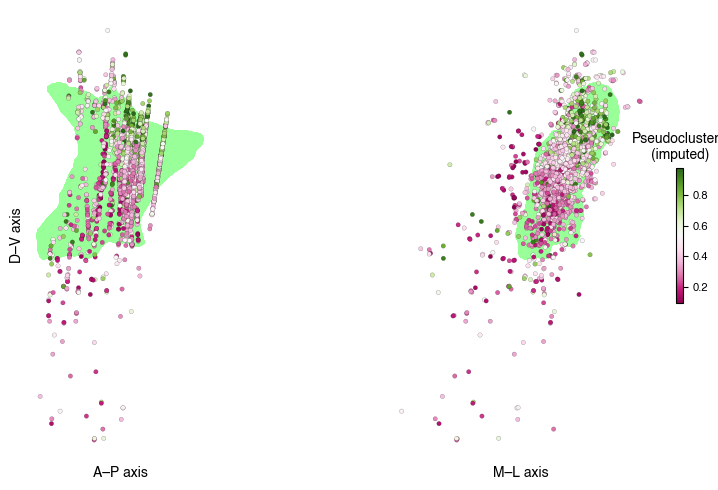

In [14]:
s = 10
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(9, 5),gridspec_kw={'width_ratios': [1, 1]})
# ——— Left: Sagittal view (direction='s') ———
plotting.plot_mesh(ax1, mesh, direction='s', meshcol='lime')
sca = ax1.scatter(
    S_mer[:, 0], S_mer[:, 1],
    c=adata_mer.obs['imputed pseudocluster'] ,
    cmap='PiYG',
    s=s,
    edgecolor='black',
    lw=0.1
)
ax1.set_aspect('equal')
ax1.set_ylabel("D–V axis")
ax1.set_xlabel("A–P axis")
ax1.set_xticks([]); ax1.set_yticks([])
for spine in ax1.spines.values():
    spine.set_visible(False)

# ——— Right: Coronal view (direction='c') ———
plotting.plot_mesh(ax2, mesh, direction='c', meshcol='lime')
sca = ax2.scatter(
    S_mer[:, 2], S_mer[:, 1],
    c=adata_mer.obs['imputed pseudocluster'] ,
    cmap='PiYG',
    s=s,
    edgecolor='black',
    lw=0.1
)
cbar = plt.colorbar(sca, ax=ax2, shrink=0.3)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_xlabel("Pseudoclusters\n(imputed)", ha='center', va='bottom')
ax2.set_aspect('equal')
ax2.set_xlabel("M–L axis")
ax2.set_xticks([]); ax2.set_yticks([])
for spine in ax2.spines.values():
    spine.set_visible(False)
    
fig.tight_layout()
save_figure("merfish_pc")
plt.show()

Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_pc_CI.svg
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_pc_CI.png


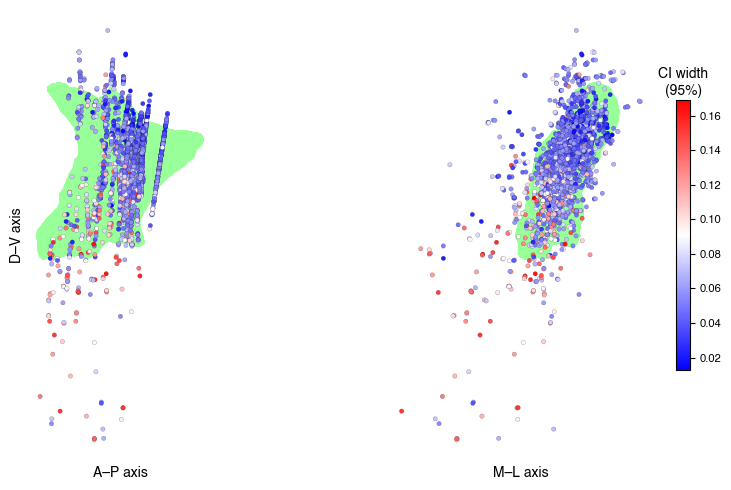

In [15]:
ci_width = conf_mer['ci_upper'] - conf_mer['ci_lower']
adata_mer.obs['pc_ci_width'] = ci_width

s = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), 
                               gridspec_kw={'width_ratios': [1, 1]})
# ——— Left: Sagittal view colored by CI width ———
plotting.plot_mesh(ax1, mesh, direction='s', meshcol='lime')
sca1 = ax1.scatter(
    S_mer[:, 0], S_mer[:, 1],
    c=adata_mer.obs['pc_ci_width'],
    cmap='bwr',
    s=s, edgecolor='black', lw=0.1
)
ax1.set_aspect('equal')
ax1.set_ylabel("D–V axis"); ax1.set_xlabel("A–P axis")
ax1.set_xticks([]); ax1.set_yticks([])
for spine in ax1.spines.values():
    spine.set_visible(False)

# ——— Right: Coronal view colored by CI width ———
plotting.plot_mesh(ax2, mesh, direction='c', meshcol='lime')
sca2 = ax2.scatter(
    S_mer[:, 2], S_mer[:, 1],
    c=adata_mer.obs['pc_ci_width'],
    cmap='bwr',
    s=s, edgecolor='black', lw=0.1
)
ax2.set_aspect('equal')
ax2.set_xlabel("M–L axis")
ax2.set_xticks([]); ax2.set_yticks([])
for spine in ax2.spines.values():
    spine.set_visible(False)
cbar2 = plt.colorbar(sca2, ax=ax2, shrink=0.6)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.set_xlabel("CI width\n(95%)", ha='center')

fig.tight_layout()
save_figure("merfish_pc_CI")
plt.show()

Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_confidence.svg
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/merfish_confidence.png


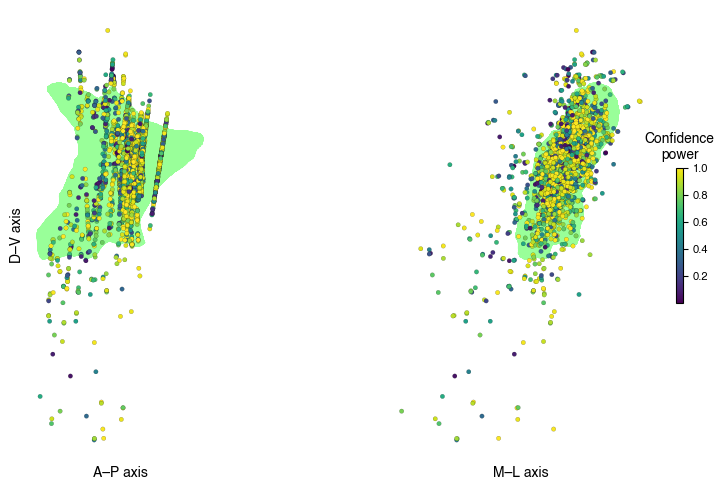

In [16]:
s = 10
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(9, 5),gridspec_kw={'width_ratios': [1, 1]})
# ——— Left: Sagittal view (direction='s') ———
plotting.plot_mesh(ax1, mesh, direction='s', meshcol='lime')
sca = ax1.scatter(
    S_mer[:, 0], S_mer[:, 1],
    c=conf_mer['conf_power'],
    s=s,
    edgecolor='black',
    lw=0.1
)
ax1.set_aspect('equal')
ax1.set_ylabel("D–V axis")
ax1.set_xlabel("A–P axis")
ax1.set_xticks([]); ax1.set_yticks([])
for spine in ax1.spines.values():
    spine.set_visible(False)

# ——— Right: Coronal view (direction='c') ———
plotting.plot_mesh(ax2, mesh, direction='c', meshcol='lime')
sca = ax2.scatter(
    S_mer[:, 2], S_mer[:, 1],
    c=conf_mer['conf_power'],
    s=s,
    edgecolor='black',
    lw=0.1
)
cbar = plt.colorbar(sca, ax=ax2, shrink=0.3)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_xlabel("Confidence\npower", ha='center', va='bottom')
ax2.set_aspect('equal')
ax2.set_xlabel("M–L axis")
ax2.set_xticks([]); ax2.set_yticks([])
for spine in ax2.spines.values():
    spine.set_visible(False)
    
fig.tight_layout()
save_figure("merfish_confidence")
plt.show()

# Visualize Retroseq DE Genes


Visualizing retroseq DE genes...


/scratch/fast/1595211/ipykernel_2864420/1291246735.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c=color_values[neworder],
/scratch/fast/1595211/ipykernel_2864420/1291246735.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c=color_values[neworder],
/scratch/fast/1595211/ipykernel_2864420/1291246735.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c=color_values[neworder],


Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/retro_DE_distrb_s.svg
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/retro_DE_distrb_s.png


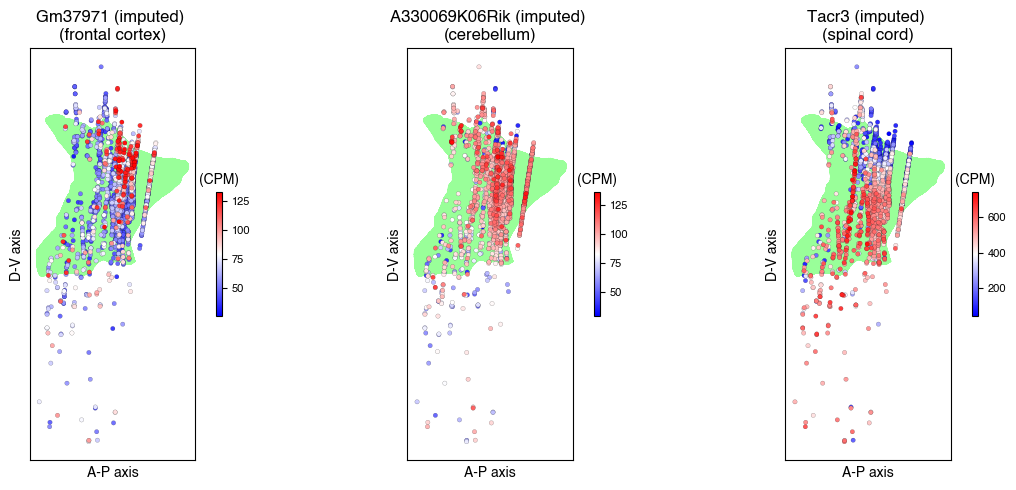

/scratch/fast/1595211/ipykernel_2864420/1291246735.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c=color_values[neworder],
/scratch/fast/1595211/ipykernel_2864420/1291246735.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c=color_values[neworder],
/scratch/fast/1595211/ipykernel_2864420/1291246735.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c=color_values[neworder],


Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/retro_DE_distrb_c.svg
Saving figure to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/retro_DE_distrb_c.png


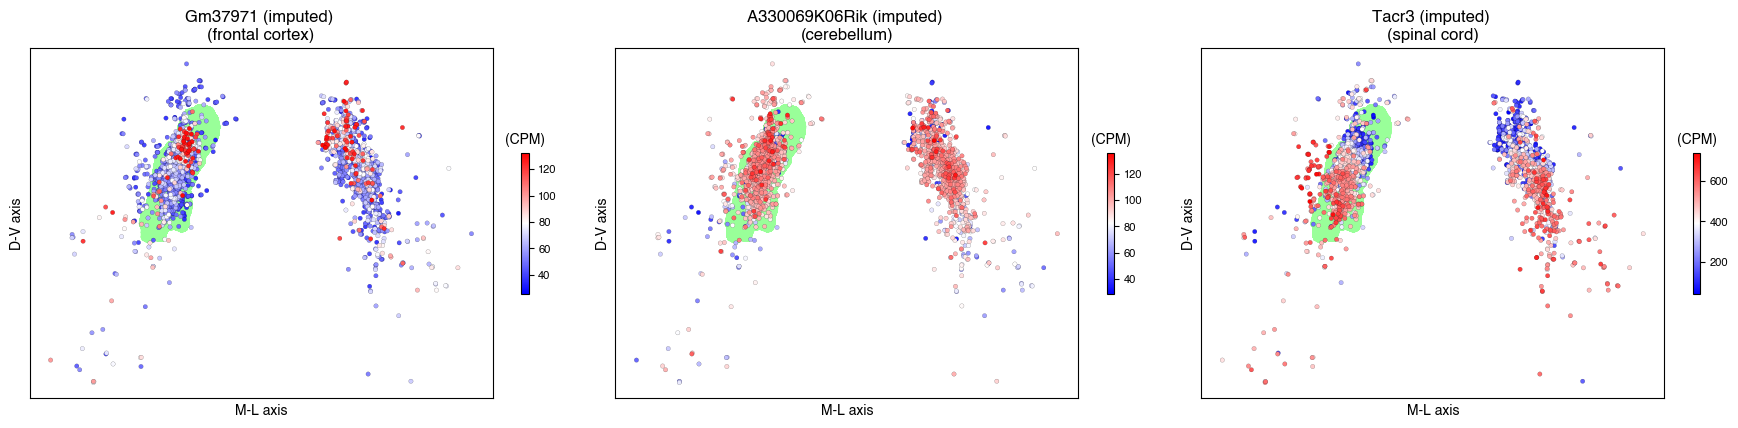

In [17]:
# Visualize retroseq DE genes
print("Visualizing retroseq DE genes...")
retro_DE_genes = np.array([['Gm37971', 'Gm43409', 'CN725425', 'Malrd1', 'Prss51'], # frontal cortex
                          ['A330069K06Rik', 'Zar1l', 'Gm18870', 'Tsix', 'Gm44127'],  # cerebellum
                          ['Tacr3', 'Syndig1', 'Pcdh7', 'Arhgap31' , 'Stxbp5l']]) # spinal cord

# Define projection sites
projectionsite_list = ['frontal cortex', 'cerebellum', 'spinal cord']

# Visualize first set of genes
genes_i_like = retro_DE_genes[:,0]

# Add imputed gene values to the original data
adata_mer = imputations.replace_imputedvalues(adata_mer, adata_mer_imputed, genes_i_like)

coords = allspatial.copy()
x_coords = coords[:, 0]
y_coords = coords[:, 1]
z_coords = coords[:, 2]

# Sagittal view
s = 10
fig, axes = plt.subplots(1, 3, squeeze=False, figsize=(12, 5))
axes = axes.flatten()
for i, gene in enumerate(genes_i_like):
    ax = axes[i]    
    color_values = adata_mer.obs[f'imput_{gene}']*1e+6
    neworder = np.argsort(color_values)
    plotting.plot_mesh(ax, allmeshes, direction='s', meshcol='lime')
    sca = ax.scatter(
        x_coords[neworder], 
        y_coords[neworder], 
        c=color_values[neworder], 
        cmap='bwr', 
        s=s, 
        edgecolor='k', 
        linewidth=0.1
    )        
    cbar = plt.colorbar(sca, ax=ax, shrink=0.3)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel("(CPM)", ha='center', va='bottom')    
    ax.set_ylabel("D-V axis")
    ax.set_xlabel("A-P axis")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{gene} (imputed) \n({projectionsite_list[i]})')
    ax.grid(False)

fig.tight_layout()    
save_figure("retro_DE_distrb_s")
plt.show()

# Coronal view
fig, axes = plt.subplots(1, 3, squeeze=False, figsize=(18, 5))
axes = axes.flatten()
for i, gene in enumerate(genes_i_like):
    ax = axes[i]
    color_values = adata_mer.obs[f'imput_{gene}']*1e+6
    neworder = np.argsort(color_values)
    plotting.plot_mesh(ax, allmeshes, direction='c', meshcol='lime')
    sca = ax.scatter(
        z_coords[neworder], 
        y_coords[neworder], 
        c=color_values[neworder], 
        cmap='bwr', 
        s=s, 
        edgecolor='k', 
        linewidth=0.1
    )        
    cbar = plt.colorbar(sca, ax=ax, shrink=0.3)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel(f"(CPM)", ha='center', va='bottom')    
    ax.set_ylabel("D-V axis")
    ax.set_xlabel("M-L axis")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{gene} (imputed) \n({projectionsite_list[i]})')
    ax.grid(False)

fig.tight_layout() 
save_figure("retro_DE_distrb_c")
plt.show()

# complete!

In [18]:
print("Analysis complete! All visualizations have been saved to:", fig_path)

Analysis complete! All visualizations have been saved to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/merfish/
